<a href="https://colab.research.google.com/github/canyue1111/CustomerMonitor/blob/main/faceCrop_emotion_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HTML SUPPORT APP


In [31]:
pip install anvil-uplink

WEBCAM CAPTURE FOR GOOGLE COLAB

In [32]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

IMPORT LIB AND DEFINE GLOBAL VALUE

ResNet-50 is a convolutional neural network that is 50 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database [1]. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.

In [47]:
#LIB NEED
import dlib
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import numpy as np
from datetime import datetime
import pandas as pd
import time
from scipy.stats import linregress
import anvil.server

#Having two dataframe store different kinds of data
df = pd.DataFrame(columns = ['Customers ID', 'Time', 'Emotion','FileName'])
da = pd.DataFrame(columns = ['Customers ID', 'Time', 'Emotion','FileName'])

emotion_class = ['Angry','Disgust','Fear', 'Happy', 'Sad','Surprise','Neutral']


In [34]:
#In this case we can use RestNet Model. also we can use transfer learning one
#(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
 
model = load_model('ResNet-50.h5')

#load detector
detector = dlib.get_frontal_face_detector()

#begin with global value of cutsomer id 0
CustomersID = 0
CustomerStatus = 0 # 0 means no facedetected, 1 means yes

In [35]:
#Function to load the cropped image
def load_image(filename):
    img = load_img(filename, grayscale=False, target_size=(197, 197))
    #convert to array
    img = img_to_array(img)
    #reshape into a single sample with  channe 3
    img = img.reshape(1, 197, 197, 3)
    #prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img


In [36]:
#crop the screenshot,image
def detect_faces(image):
    # Run detector and get bounding boxes of the faces on image.
    detected_faces = detector(image, 1)
    face_frames = [(x.left(), x.top(),
                    x.right(), x.bottom()) for x in detected_faces]

    #multi faces
    return face_frames 

In [37]:
def trans_da(n):
  #Angry Disgust 1 Fear Sad 2 Neutral 3 Surprise 4 Happy 5
  #negative emotion it is, lower number it will be
  if n == 'Angry':
    return 1
  if n == 'Disgust':
    return 1
  if n == 'Fear':
    return 2
  if n == 'Happy':
    return 5
  if n == 'Sad':
    return 2
  if n == 'Surprise':
    return 4
  if n == 'Neutral':
    return 4.2
  else: return n



In [38]:
def check_Face_Exist(img_path):
  max_score = 0.99
  # Detect faces http://dlib.net/face_detector.py.html
  img = dlib.load_rgb_image(img_path)
  
  #get the scores from detectors, determining whether they detect face or not
  dets, scores, idx = detector.run(img, 1,-1)
  for i, d in enumerate(dets):
      if scores[i]> max_score:
        max_score = scores[i]
  
  #personally setting, if score is over 1.0 which means there is face exist
  if max_score > 1.0:
    return True
  else:
    return False


In [39]:
import anvil.media

In [46]:
#Connect the client website
anvil.server.connect("E6U72W7FISS5UWOI3GLS4YOX-N2IDQ4SYIEBLIFFM")

@anvil.server.callable
def trans_int_da():
  return df.to_dict('records')

#calculate customer emotion tendency, employee performance
@anvil.server.callable
def Customer_Performance(_id):
  try:
    id = int(_id)
    if id in da["Customers ID"].values:
      temp = da[da["Customers ID"] == id]
      slope, intercept, r_value, p_value, std_err = linregress(temp.index, temp['Emotion'].astype(float))
      a = slope*80 + temp.iloc[-1]['Emotion']*10 + std_err*10
      title_temp = "Customer ID "+ str(id) + " Performance is "+ str(a)
      return  title_temp
    else:  
      return "That "+ _id +" Customers ID NOT EXIST"
  except:
    return "Not Valid"

@anvil.server.callable
def lastThreeAngry():
  #last 5 emotion average is lower than 2.3 and all of them has negative emotion
  return (len(da.tail(5)[da['Emotion'] < 4]) == 5) & (da.tail(5)['Emotion'].mean()<2.3)

@anvil.server.callable
def Customer_coming():
  #If there is customer exis, notify to employee
  return CustomerStatus == 1

@anvil.server.callable
def make_data():
  df.to_csv("df.csv") 
  X_media = anvil.media.from_file('df.csv', 'csv', 'df')
  return X_media

#Customers shows surprise for the latest update
@anvil.server.callable
def lastThreeSurprise():
  return (len(da.tail(5)[da['Emotion'] == 4]) >= 3) 


#Customers shows Fear and sad
@anvil.server.callable
def lastThreeFear():
  return (len(da.tail(5)[da['Emotion'] == 2]) >= 3) 

#Customers shows Happy giving encourage
@anvil.server.callable
def lastThreeHappy():
  return (len(da.tail(5)[da['Emotion'] == 5]) >= 3) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Face Detected


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


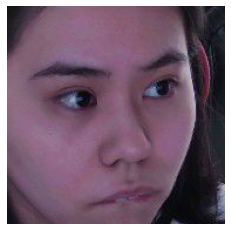

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [48]:
#update= running or not
update_ = True

#temp cam shot
img_path = 'photo.jpg'

while update_:
  #update every 2 seconds
  time.sleep(2)
  #take photo and save as photo.jpg
  filename = take_photo()

  if check_Face_Exist(img_path):
    print("Face Detected")
    CustomerStatus = 1
    image = io.imread(img_path)
    detected_faces = detect_faces(image)

  # Crop faces and plot
    for n, face_rect in enumerate(detected_faces):
      face = Image.fromarray(image).crop(face_rect)
      #Get the time now
      now = datetime.now()
      today = now.strftime("%H:%M:%S")
      #file name setting
      name = str(today) + '.png'
      #save file
      plt.savefig(name)

      # emotion_class[np.argmax(model.predict(load_image("file/" + name)))]
      addition=pd.DataFrame( {'Customers ID': [CustomersID],
                              'Time': [today],
                              'Emotion':  [emotion_class[np.argmax(model.predict(load_image(name)))]],
                              'FileName':[name]})
      #add to df dataframe
      df = df.append(addition, ignore_index=True)
      #add to da dataframe, after transfering emotion 'string' to 'float'.
      addition['Emotion'] = addition['Emotion'].apply(trans_da)
      da = da.append(addition, ignore_index=True)

    plt.subplot(1, len(detected_faces), n+1)
    plt.axis('off')
    plt.imshow(face)
  
  else:
    print("NofaceDetected")
    if CustomerStatus == 1:
      CustomerStatus = 0
      CustomersID = CustomersID + 1



In [49]:
da.head()

,Customers ID,Time,Emotion,FileName
0,1,15:33:03,4.2,15:33:03.png
1,1,15:33:07,2.0,15:33:07.png
2,1,15:33:11,5.0,15:33:11.png
3,1,15:33:15,5.0,15:33:15.png
4,1,15:33:19,4.2,15:33:19.png


In [50]:
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Customers ID,Time,Emotion,FileName
0,1,15:33:03,Neutral,15:33:03.png
1,1,15:33:07,Fear,15:33:07.png
2,1,15:33:11,Happy,15:33:11.png
3,1,15:33:15,Happy,15:33:15.png
4,1,15:33:19,Neutral,15:33:19.png


#EDA


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Customers ID,Time,Emotion,FileName
0,1,15:33:03,4.2,15:33:03.png
1,1,15:33:07,2.0,15:33:07.png
2,1,15:33:11,5.0,15:33:11.png
3,1,15:33:15,5.0,15:33:15.png
4,1,15:33:19,4.2,15:33:19.png
5,1,15:33:22,5.0,15:33:22.png
6,1,15:33:26,4.2,15:33:26.png
7,1,15:33:30,5.0,15:33:30.png
8,1,15:33:34,5.0,15:33:34.png
9,1,15:33:37,2.0,15:33:37.png


'slope is -0.01987755102040816'

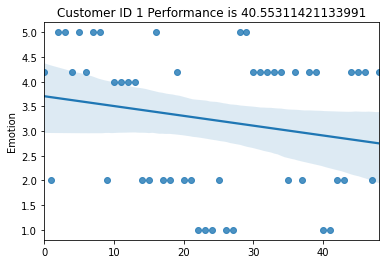

In [51]:
import seaborn as sns

def Customer_Performance(_id,_dataframe):
  #get the dataframe which cutsomer id is _id
  temp = _dataframe[_dataframe["Customers ID"] == _id]
  
  #swith emotion value to float
  temp['Emotion'] = temp['Emotion'].astype(float).dropna()

  slope, intercept, r_value, p_value, std_err = linregress(temp.index.astype(float), 
                                                           temp['Emotion'].astype(float))
  
  title_temp = "Customer ID "+ str(_id) + " Performance is "+ str(slope*80
                                                                  + temp.iloc[-1]['Emotion']*10
                                                                  + std_err*10)
  sns.regplot(x=temp.index, 
              y='Emotion', 
              data=temp, 
              fit_reg=True).set_title(title_temp)

  display(temp,"slope is " + str(slope))

#if ask which kind of customers
#if customer id is 1
Customer_Performance(1,da)